In [ ]:
# 

In [20]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from PIL import Image

from tensorflow.keras.utils import normalize
import warnings
warnings.filterwarnings("ignore")

In [21]:
train_img_path = "/home/robin/assignment Folder/U_NET/images/train/"
val_img_path = "/home/robin/assignment Folder/U_NET/images/val/"

train_mask_path = "/home/robin/assignment Folder/U_NET/masks/train/"
val_mask_path = "/home/robin/assignment Folder/U_NET/masks/val/"

In [22]:
SIZE = 224

train_img_data = []
val_img_data = []
train_mask_data = []
val_mask_data = []

In [23]:
len(train_img_data), len(train_mask_data), len(val_img_data), len(val_mask_data)

(0, 0, 0, 0)

In [24]:
train_images = os.listdir(train_img_path)

In [25]:
len(train_images)

1001

In [28]:
sort_train_img = sorted(train_images)

In [30]:
sort_train_img[0]

'.ipynb_checkpoints'

In [31]:
sort_train_img.remove('.ipynb_checkpoints')

In [32]:
sort_train_img[:5]

['00054602-3bf57337.jpg',
 '001c2a14-c7138401.jpg',
 '002d467e-00000000.jpg',
 '004071a4-049be89b.jpg',
 '004fd763-ad4c2b9c.jpg']

In [33]:
train_masks = os.listdir(train_mask_path)

In [34]:
len(train_masks)

1000

In [35]:
sort_train_mask = sorted(train_masks)

In [36]:
sort_train_mask[:5]

['00054602-3bf57337.png',
 '001c2a14-c7138401.png',
 '002d467e-00000000.png',
 '004071a4-049be89b.png',
 '004fd763-ad4c2b9c.png']

In [37]:

for i, image_name in enumerate(sort_train_img):    
    if (image_name.split('.')[1] == 'jpg'):
        #print(image_directory+image_name)
        image = cv2.imread(train_img_path+image_name, 0)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        train_img_data.append(np.array(image))

In [38]:
# # for validation imges

# for i, image_name in enumerate(val_images):
#     if (image_name.split('.')[1] == 'jpg'):
#         image = cv2.imread(val_img_path+image_name, 0)
#         image = Image.fromarray(image)
#         image = image.resize((SIZE,SIZE))
#         val_img_data.append(np.array(image))

In [39]:
# for training masks

for i, image_name in enumerate(sort_train_mask):
    if (image_name.split('.')[1] == 'png'):
        image = cv2.imread(train_mask_path+image_name, 0)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        train_mask_data.append(np.array(image))

In [67]:
# # for validation masks

# val_masks = os.listdir(val_mask_path)

# for i, image_name in enumerate(val_masks):
#     if (image_name.split('.')[1] == 'png'):
#         image = cv2.imread(val_mask_path+image_name, 0)
#         image = Image.fromarray(image)
#         image = image.resize((SIZE, SIZE))
#         val_mask_data.append(np.array(image))

In [40]:
# Normalize images
train_img_data = np.expand_dims(normalize(np.array(train_img_data), axis=1),3)
#val_img_data = np.expand_dims(normalize(np.array(val_img_data), axis=1),3)

# rescale to 0 to 1.
train_mask_data = np.expand_dims((np.array(train_mask_data)),3) /255.
#val_mask_data = np.expand_dims((np.array(val_mask_data)),3) /255.

In [41]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test =train_test_split(train_img_data, train_mask_data,test_size = 0.10, random_state = 0)


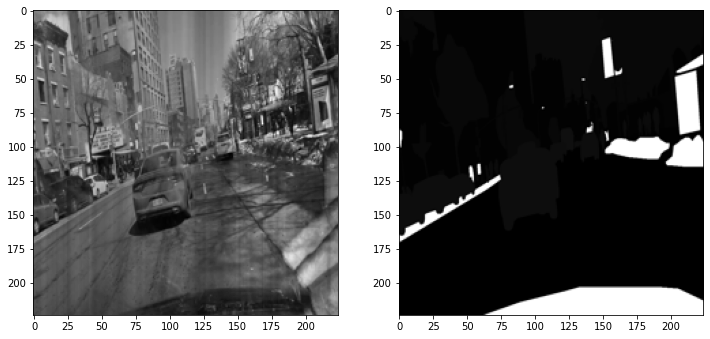

In [42]:
#Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(X_train))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(X_train[image_number], (224, 224)), cmap='gray')
plt.subplot(122)
plt.imshow(np.reshape(y_train[image_number], (224, 224)), cmap='gray')

plt.show()

In [43]:
IMG_HEIGHT = train_img_data.shape[1]
IMG_WIDTH  = train_img_data.shape[2]
IMG_CHANNELS = train_img_data.shape[3]

In [44]:
print(IMG_HEIGHT)
print(IMG_WIDTH)
print(IMG_CHANNELS)

224
224
1


In [45]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.layers import Conv2DTranspose, BatchNormalization, Dropout, Lambda

In [46]:
def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    
    return model

In [47]:
def get_model():
    return simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

In [48]:
model = get_model()

2022-06-09 20:31:03.552389: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/robin/.local/lib/python3.8/site-packages/cv2/../../lib64:
2022-06-09 20:31:03.566401: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-09 20:31:03.677897: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (robin-Aspire-E5-473): /proc/driver/nvidia/version does not exist
2022-06-09 20:31:03.754496: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 224, 224, 16  0           ['conv2d[0][0]']                 
                                )                                                             

In [50]:
history = model.fit(X_train, y_train, 
                    batch_size = 32, 
                    verbose=1, 
                    epochs=5, 
                    validation_data=(X_test, y_test), 
                    shuffle=False)

model.save('road_image_segmentation_1000_imgs_UNET_model.h5')

Epoch 1/5
29/29 [==============================] - 346s 11s/step - loss: 0.5217 - accuracy: 0.2185 - val_loss: 0.4758 - val_accuracy: 0.2079
Epoch 2/5
29/29 [==============================] - 326s 11s/step - loss: 0.4645 - accuracy: 0.2186 - val_loss: 0.4672 - val_accuracy: 0.2079
Epoch 3/5
29/29 [==============================] - 318s 11s/step - loss: 0.4201 - accuracy: 0.2511 - val_loss: 0.4494 - val_accuracy: 0.2713
Epoch 4/5
29/29 [==============================] - 317s 11s/step - loss: 0.4001 - accuracy: 0.2827 - val_loss: 0.3718 - val_accuracy: 0.2742
Epoch 5/5
29/29 [==============================] - 316s 11s/step - loss: 0.3722 - accuracy: 0.2929 - val_loss: 0.3587 - val_accuracy: 0.2847


In [51]:
_, acc = model.evaluate(X_test, y_test)
print("Accuracy = ", (acc * 100.0), "%")

4/4 [==============================] - 9s 2s/step - loss: 0.3587 - accuracy: 0.2847
Accuracy =  28.46982479095459 %


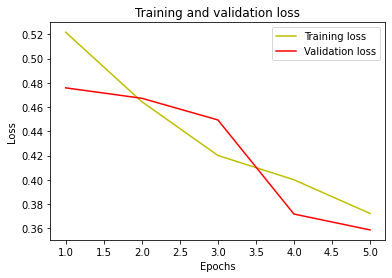

In [52]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


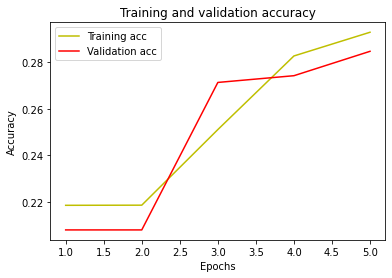

In [53]:
#acc = history.history['acc']
acc = history.history['accuracy']
#val_acc = history.history['val_acc']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [54]:
#IOU
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

intersection = np.logical_and(y_test, y_pred_thresholded)
union = np.logical_or(y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

IoU socre is:  0.13908285837642612


In [55]:
#initialize our callbacks

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

model_path = ("road_segmentation_u_net.h5")
checkpoint = ModelCheckpoint(model_path,
                             monitor = "val_loss",
                             mode = "min",
                             save_best_only = True,
                             verbose = 1)

earlystop = EarlyStopping(monitor = "val_loss",
                          min_delta = 0,
                          patience = 5,
                          verbose = 1,
                          restore_best_weights = True)

callbacks = [checkpoint, earlystop]

In [56]:
history = model.fit(X_train, y_train, 
                    batch_size = 16,
                    callbacks = callbacks,
                    verbose=1, 
                    epochs=10, 
                    validation_data=(X_test, y_test), 
                    shuffle=False)

model.save('road_image_segmentation_1000_imgs_10_epochs_UNET_model.h5')

Epoch 1/10
57/57 [==============================] - ETA: 0s - loss: 0.4274 - accuracy: 0.2489
Epoch 00001: val_loss improved from inf to 0.40205, saving model to road_segmentation_u_net.h5
57/57 [==============================] - 349s 6s/step - loss: 0.4274 - accuracy: 0.2489 - val_loss: 0.4021 - val_accuracy: 0.2561
Epoch 2/10
57/57 [==============================] - ETA: 0s - loss: 0.3986 - accuracy: 0.2775
Epoch 00002: val_loss improved from 0.40205 to 0.37291, saving model to road_segmentation_u_net.h5
57/57 [==============================] - 315s 5s/step - loss: 0.3986 - accuracy: 0.2775 - val_loss: 0.3729 - val_accuracy: 0.2799
Epoch 3/10
57/57 [==============================] - ETA: 0s - loss: 0.3703 - accuracy: 0.2942
Epoch 00003: val_loss improved from 0.37291 to 0.35527, saving model to road_segmentation_u_net.h5
57/57 [==============================] - 340s 6s/step - loss: 0.3703 - accuracy: 0.2942 - val_loss: 0.3553 - val_accuracy: 0.2813
Epoch 4/10
57/57 [=================